In [2]:
from iminuit import Minuit, cost
import matplotlib.pyplot as plt 
import pandas as pd 
import numpy as np 
# from tiling_disk_plots import coordinates_plot
import sys
sys.path.append('..')
from disk_analysis_tools import tiling_disk_plots as tdp
from disk_analysis_tools import tiling_disk_utils as tdu
from disk_analysis_tools import tiling_disk_optim as optim
from scipy.stats import median_abs_deviation as mad_func
mad_str = 'median_abs_deviation'
from astropy.stats import knuth_bin_width

import seaborn as sns
%matplotlib inline
sns.set_theme(style="ticks")
sns.set_context("paper")

study on how and why would it be usefull to bootstrap data and bit of statistical test on normality at the end

In [3]:
def Bootstrap(data, statistic, alpha=0.95, n_samples=10000):
    from scipy.special import erfinv
    from astropy.stats import bootstrap
    # credits to: Jack Rolph 
    if not (0 < alpha < 1):
        raise ValueError("confidence level must be in (0, 1)")

    n = n_samples
    if n <= 0:
        raise ValueError("data must contain at least one measurement.")
        
    boot_stat = bootstrap(data, n_samples, bootfunc=statistic)
    stat_data = statistic(data)
    mean_stat = np.mean(boot_stat)
    est_stat = 2*stat_data - mean_stat
    std_err = np.std(boot_stat)
    z_score = np.sqrt(2.0)*erfinv(alpha)
    conf_interval = est_stat + z_score*np.array((-std_err, std_err))
    
    
    return est_stat, std_err, conf_interval

In [4]:
def Bootstrap_mean_est(data):
    return Bootstrap(data.values, np.mean, alpha=0.95, n_samples=10_000)

def Bootstrap_median_est(data):
    return Bootstrap(data.values, np.median, alpha=0.95, n_samples=10_000)

def median_error(data): 
    q_low, q_high = data.quantile(q=[0.025, 0.9725])
    return (q_high - q_low) / 2*np.sqrt(13) #  13 measurements in one point

def mean_error(data): 
    return np.std(data) / np.sqrt(13)

In [5]:
def measurement_error(data): 
    return np.sqrt(mean_error**2 + LAO_ERROR**2)

In [16]:
from pathlib import Path
measurement_folder  = Path.cwd().parent.parent / 'measurements' / 'Tisch'

In [17]:
measurement_folder

WindowsPath('c:/Users/Domin/Nextcloud/Master/Disk_Tiling_Measurements/MADMAX_disk_analysis/measurements/Tisch')

In [42]:
table_map = tdu.read_single_measurement(measurement_folder, '20211214_table_top.txt')
table_map = tdu.df_convert_unix_to_datetime(table_map)
# table_map = table_map.query('-158 < z')

In [21]:
def point_table(dataframe):
    from scipy.stats import median_abs_deviation as mad  
    mad_str = 'median_abs_deviation'
    """returns DF pivot table with mean, std and median of z by points on the hexagon"""
    point_table = pd.pivot_table(dataframe, values=['x','y','z'], index=['hex_nr', 'point'],
                            aggfunc={
                                'x': np.mean,
                                'y': np.mean,
                                'z': [np.mean, mean_error, np.median, median_error ,Bootstrap_mean_est,Bootstrap_median_est],})
    point_table[('x','mean')] = point_table[('x','mean')].apply(lambda x: round(x,2))
    point_table[('y','mean')] = point_table[('y','mean')].apply(lambda x: round(x,2))
    return point_table

In [43]:
table_map.z = tdu.subtract_mean(table_map.z)

(<Figure size 504x432 with 1 Axes>,
 <AxesSubplot:xlabel='z [µm]', ylabel='Count'>)

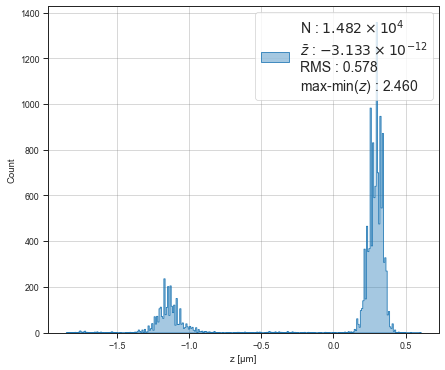

In [44]:
tdp.ts_hist(table_map, mode='z')

In [45]:
table_map = table_map.loc[table_map.z < 0]

In [46]:
table_map.z = tdu.subtract_mean(table_map.z)

(<Figure size 504x432 with 1 Axes>,
 <AxesSubplot:xlabel='z [µm]', ylabel='Count'>)

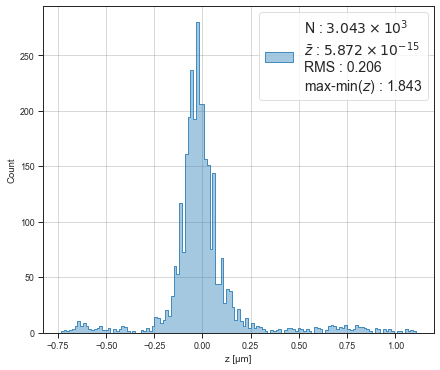

In [47]:
tdp.ts_hist(table_map, mode='z')

In [25]:
# data = table_map.query('hex_nr == 1')
# for p in range(0, 60, 1): 
#     data.query(f'point == {p}').hist('z')

In [26]:
# table_map = tdu.subtract_mean(table_map)

In [27]:
table_map_pt = point_table(table_map)

In [28]:
def mean_median(data): 
    mean_median_percent = [np.abs(mean-median)/std for mean, median, std in zip(data['z', 'mean'], data['z', 'median'], data['z', 'mean_error']*np.sqrt(13) )]
    fig,ax = plt.subplots(1,1)
    ax.plot([i for i in range(0,len(mean_median_percent),1)], mean_median_percent, label='percent mean - median / std')#
    return fig, ax 

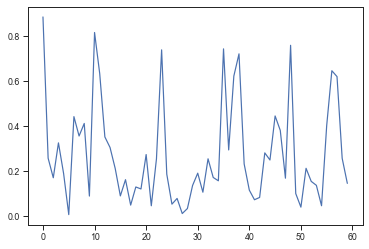

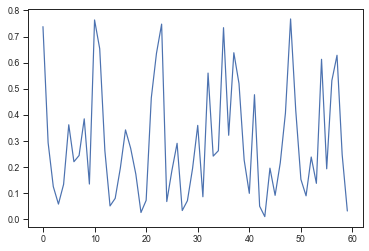

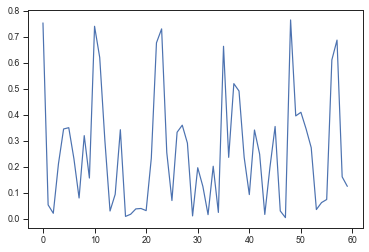

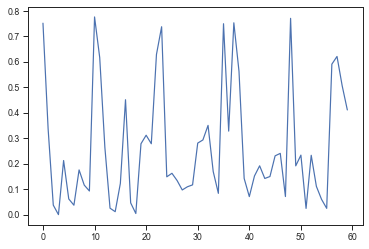

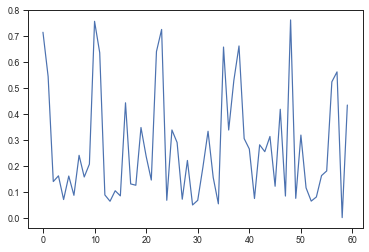

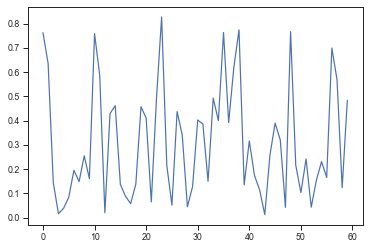

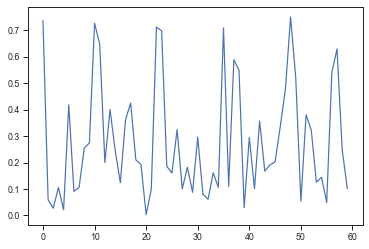

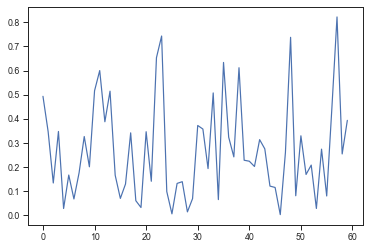

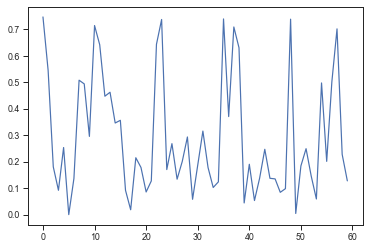

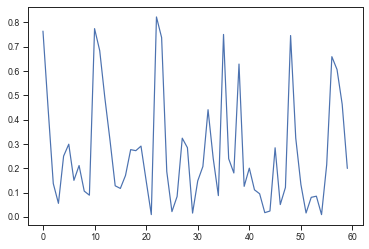

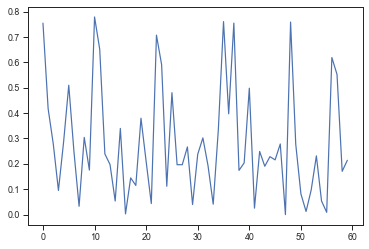

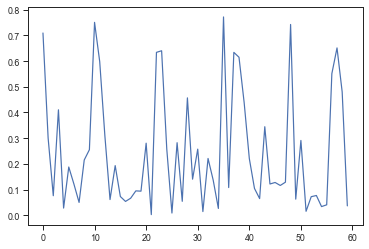

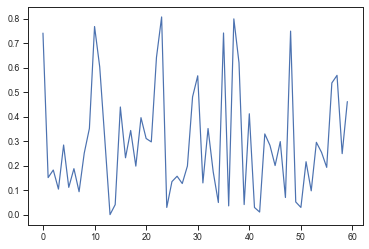

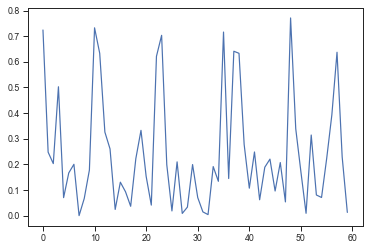

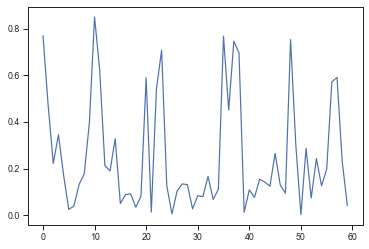

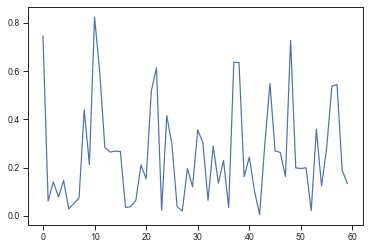

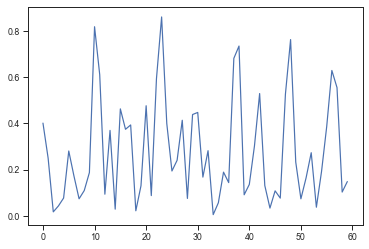

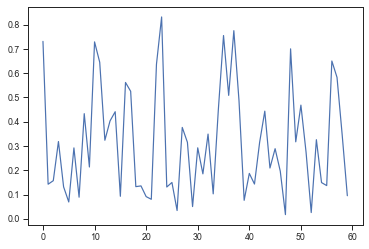

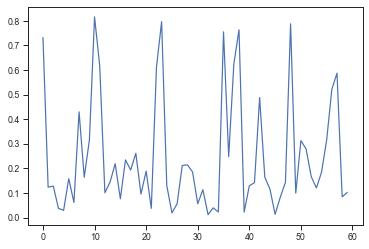

In [29]:
hexagons = list(range(1,20,1))
for hexagon in hexagons: 
    data = table_map_pt.query(f'hex_nr == {hexagon}')
    mean_median(data)

In [30]:
def mean_comp_plot(data): 
    fig,ax = plt.subplots(1,1)
    s = data['z','Bootstrap_mean_est'].values
    mean_bootstrap = [x[0] for x in s]
    t = data['z','Bootstrap_median_est'].values
    median_bootstrap = [x[0] for x in t]
    ax.plot([i for i in range(0,len(t),1)], data['z', 'mean'], label='mean')
    ax.plot([i for i in range(0,len(t),1)], data['z', 'median'], label='median')
    plt.plot([i for i in range(0,len(t),1)], median_bootstrap, label='bs median')
    plt.plot([i for i in range(0,len(t),1)], mean_bootstrap, label='bs mean')
    plt.legend()

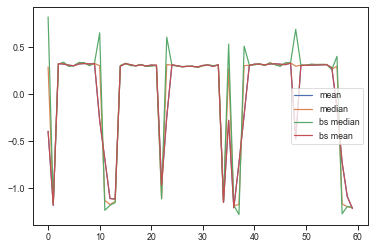

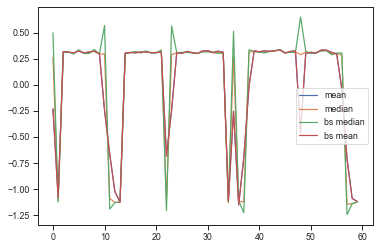

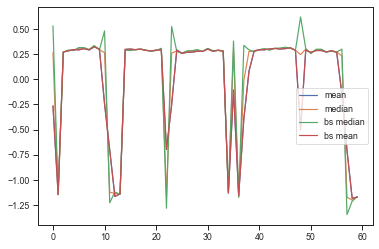

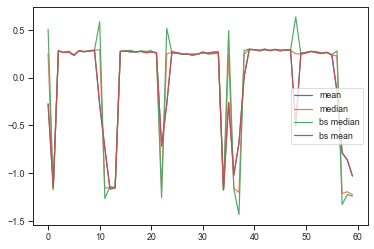

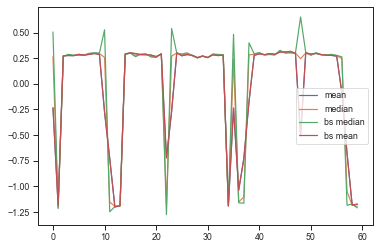

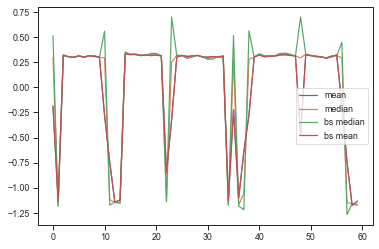

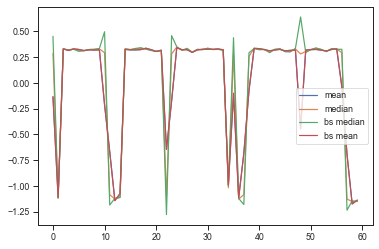

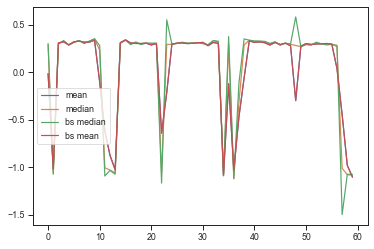

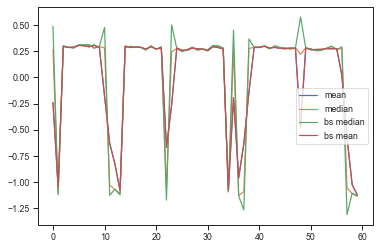

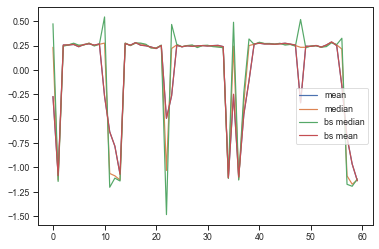

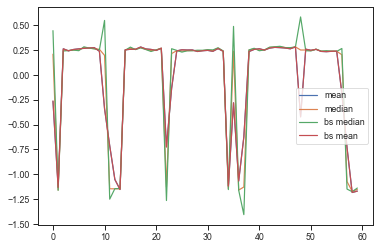

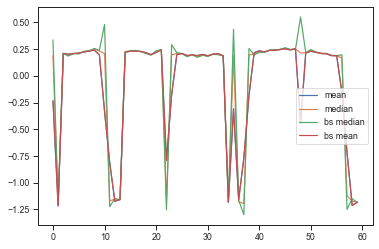

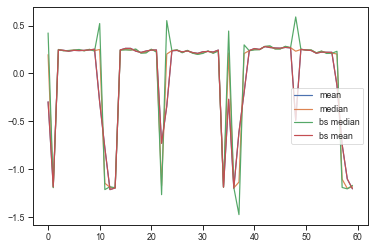

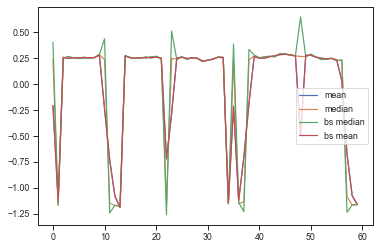

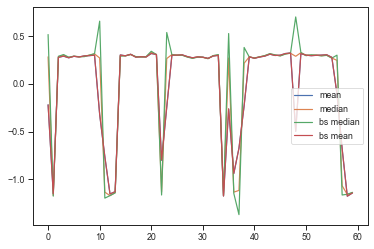

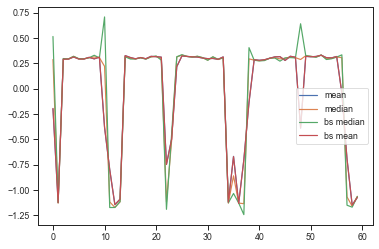

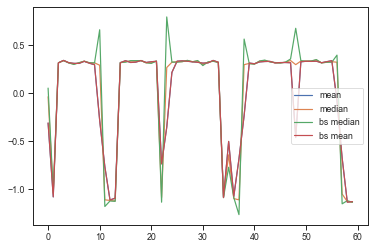

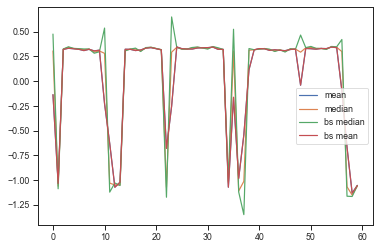

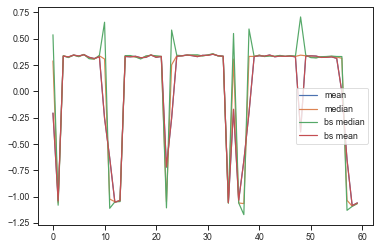

In [31]:
hexagons = list(range(1,20,1))
for hexagon in hexagons: 
    data = table_map_pt.query(f'hex_nr == {hexagon}')
    mean_comp_plot(data)

In [32]:
def std_comp_plot(data): 
    fig,ax = plt.subplots(1,1)
    s = data['z','Bootstrap_mean_est'].values
    std_mean_bootstrap = [x[1] for x in s]
    t = data['z','Bootstrap_median_est'].values
    std_median_bootstrap = [x[1] for x in t]
    
    v=data['z','Bootstrap_mean_est'].values
    std_cl_mean_bootstrap = [ (x[2][1] - x[2][0])/2*np.sqrt(13) for x in v]
    w=data['z','Bootstrap_median_est'].values
    std_cl_median_bootstrap = [(x[2][1] - x[2][0])/2*np.sqrt(13) for x in w]
    
    ax.plot([i for i in range(0,len(t),1)], data['z', 'mean_error'], label='mean_err')
    plt.plot([i for i in range(0,len(t),1)], std_median_bootstrap, label='bs median_err')
    plt.plot([i for i in range(0,len(t),1)], std_mean_bootstrap, label='bs mean_err')
    ax.plot([i for i in range(0,len(t),1)], data['z', 'median_error'], label='median_err')
    plt.plot([i for i in range(0,len(t),1)], std_cl_median_bootstrap, label='bs cl_median_err')
    plt.plot([i for i in range(0,len(t),1)], std_cl_mean_bootstrap, label='bs cl_mean_err')
    # print(std_median_bootstrap)
    plt.legend()

In [33]:
hexagons = list(range(1,20,1))
for hexagon in hexagons: 
    data = table_map_pt.query(f'hex_nr == {hexagon}')
    print(data['z', 'mean_error'])

hex_nr  point
1       1        0.213814
        2        0.009804
        3        0.006205
        4        0.011352
        5        0.008608
        6        0.007942
        7        0.007357
        8        0.005907
        9        0.008723
        10       0.010611
        11       0.196226
        12       0.190584
        13       0.049559
        14       0.023245
        15       0.006897
        16       0.007716
        17       0.008749
        18       0.008901
        19       0.005863
        20       0.005766
        21       0.007444
        22       0.009001
        23       0.158529
        24       0.208390
        25       0.006817
        26       0.005868
        27       0.009872
        28       0.008326
        29       0.006675
        30       0.010085
        31       0.005103
        32       0.005746
        33       0.007912
        34       0.008004
        35       0.006466
        36       0.203748
        37       0.021077
        38       0.19379

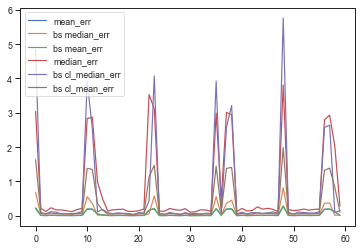

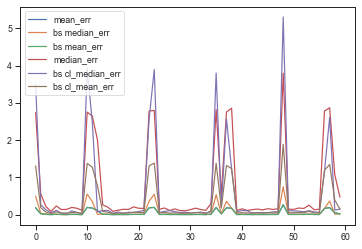

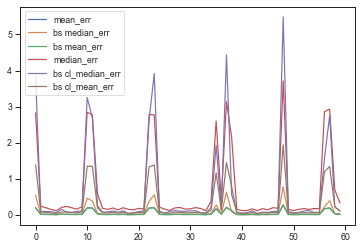

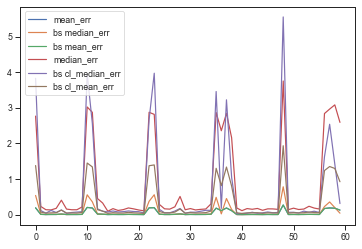

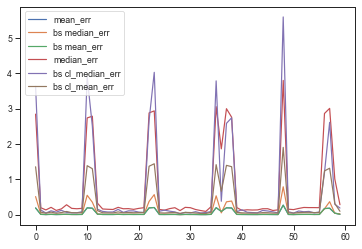

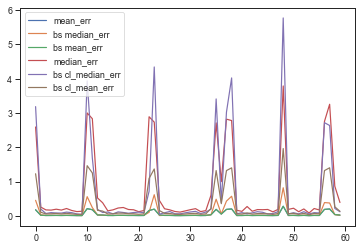

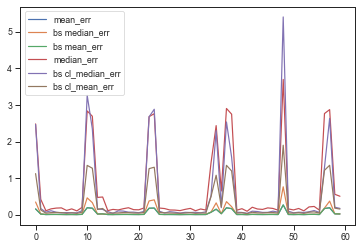

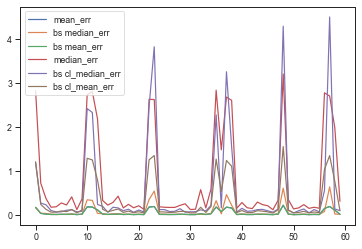

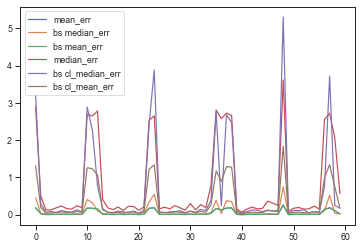

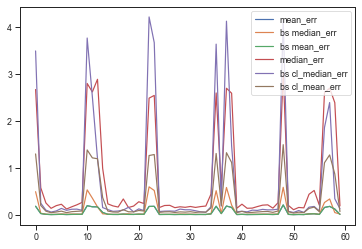

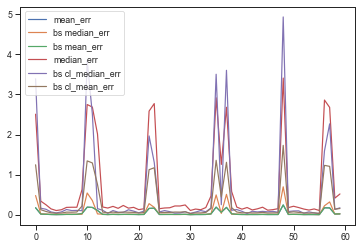

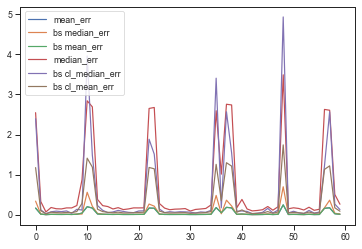

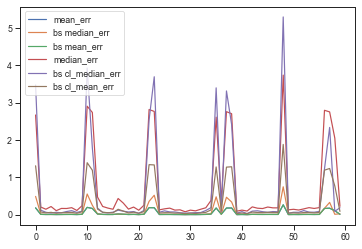

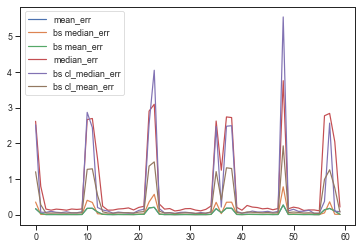

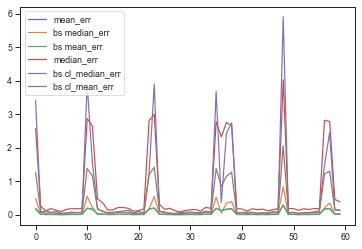

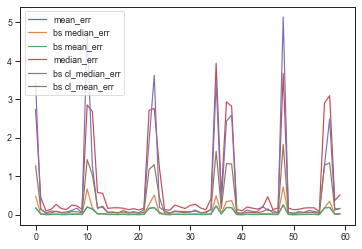

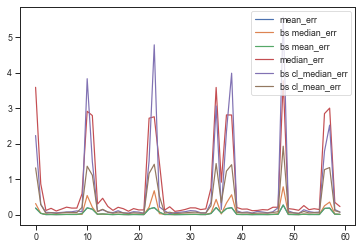

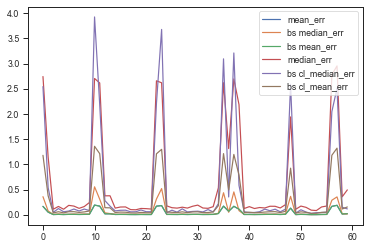

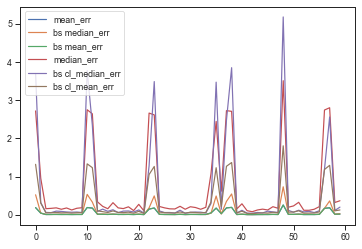

In [34]:
hexagons = list(range(1,20,1))
for hexagon in hexagons: 
    data = table_map_pt.query(f'hex_nr == {hexagon}')
    std_comp_plot(data)

In [35]:
error_measurement = 35 #* [µm]
data = table_map['z']
µ_est, std_est, conf_interval = Bootstrap(data.values, np.mean, alpha=0.95, n_samples=10_000)

print(µ_est, std_est, conf_interval)

1.2710450369267532e-05 0.004751470207079425 [-0.0093      0.00932542]


In [36]:
data = table_map['z']
µ_est_, std_est_, conf_interval_ = Bootstrap(data.values, np.median)
print(µ_est_, std_est_, conf_interval_)

0.2749137198511079 0.002088588193014681 [0.27082016 0.27900728]


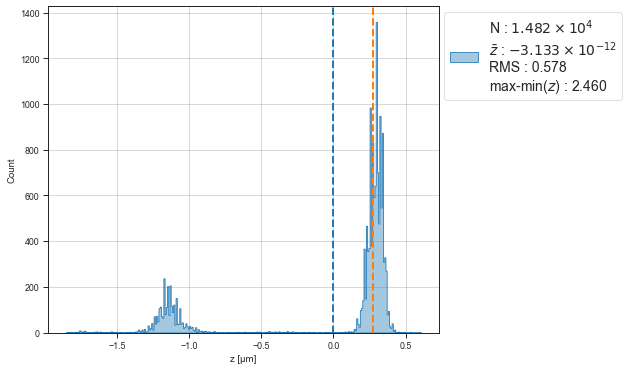

In [37]:
fig, ax = tdp.ts_hist(table_map)
ax.axvline(µ_est, ls='--',c='tab:blue', linewidth=2,)
ax.axvline(µ_est_, ls='--',c='tab:orange', linewidth=2,)
# tdp.hist_error_band(ax, µ_est, conf_interval[0]+µ_est, c_mean='tab:blue', c_std='tab:orange', label_mean='', label_std='')
# tdp.hist_error_band(ax, µ_est_, conf_interval_[0]+µ_est_, c_mean='tab:cyan', c_std='tab:red', label_mean='', label_std='')

In [38]:
from scipy.stats import shapiro
all_shapieros_bool = []
all_shapieros_val = []
for hexagon in range(1,20,1):
    # for point in range(1,61,1):
    data_to_test = table_map_pt.query(f'hex_nr == {hexagon}')
    # print(data_to_test['z'])
    data_to_test = data_to_test['z', 'median'].to_numpy()
    s = shapiro((data_to_test))
    conf_lvl = 0.05
    if s.pvalue >= conf_lvl:
        all_shapieros_bool.append(True)
        all_shapieros_val.append(s.pvalue)
    else:
        all_shapieros_bool.append(False)
        all_shapieros_val.append(s.pvalue)

In [39]:
all_shapieros_bool

[False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False]

In [40]:
table_map['s_bool'] = all_shapieros_bool
table_map['s_val'] = all_shapieros_val

ValueError: Length of values (19) does not match length of index (14818)